# Ziel dieser Auswertung
Es soll eine Antwort darüber gegeben werden, inwiefern sich die bisher analysierten Features auf den klinischen Bildern von aufrecht stehenden Kindern mit Röntgenbildern korrelieren lassen.


## Erklärungen zu den Parametern

* MaxWaistAngle/MinWaistAngle:  
  gibt den größten/kleinsten Winkel zwischen den einzelnen Waistpunkten (links -> rechts) zurück
  

* Curvature Difference:  
  berechnet den Krümmungsradius aus 2. und 1. Ableitung der Waistlinie. Größere Werte = stärkere Krümmung. Es wird die Differenz links-rechts berechnet und der Betrag davon zurückgegeben.
  
* CurvatureMaxDifference:  
  gibt den Unterschied der Maximalkrümmungen zurück.

* ShoulderHeightDifference:  
  Ermittelt die Differenz von Beginn rechter - linker Waistlinie. Da die y-Achse des Koordinatensystems umgedreht ist, sind negative Werte als Schulter- bzw. Achselhochstand rechts zu interpretieren. Die Werte sind normiert gegen den Schulterabstand (=x-Werte der ersten Waistline-Punkte)
  

* WaistPointHeightDifference:  
  Ermittelt den von oben gesehen ersten Punkt, der am weitesten innen liegt. Davon wird der y-Wert bestimmt, die Differenz zwischen rechts und links gebildet und gegen den Schulterabstand normiert. Negative Werte heissen: rechts steht höher.
  

* WaistAreaDifferences:  
  Die Waistlines werden 90° gedreht (links) oder 90° gedreht und geflipt (rechts), so dass y=x und dann der Start auf x=0 gesetzt. Dann werden die Flächen darunter berechnet, nachdem die Waistline noch interpoliert wurde. Die Flächen werden auf eine Länge (Schulterabstand) begrenzt und als Quartile ausgegeben (1. Viertel oben an der Axilla, 4. Viertel unten auf Hosenhöhe = Schulterabstand gibt Länge vor). Es wird die Differenz zwischen den Flächen rechts - links gebildet und dann durch den Schulterabstand geteilt.
  
  
* HumpAngle:  
  Gibt den Winkel des Rippenbuckels wider. Positive Werte heissen: rechts steht höher

In [1]:
import numpy as np
import pandas as pd
import json
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


%matplotlib inline

experiment_name='Test2'

configfile='scol_detect_pkg_config.json'
with open(configfile) as f:
    configparams=json.load(f)


## Einlesen der Daten und Erstverarbeitung

In [2]:
## Einlesen der Daten und Erstverarbeitung

df_ntc=pd.read_pickle('finalFeatures-ntc1.pkl')

df_ntc.index

df=pd.read_pickle(configparams['final_df'])

df.head(10)

df=pd.concat([df,df_ntc])

In [4]:
df.describe()

,MaxWaistAngle,MinWaistAngle,CurvatureDifference,CurvatureMaxDifference,ShoulderHeightDifference,WaistPointHeightDifference,HumpAngle
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,4.460018,-1.866154,0.002909,0.015959,0.004667,-0.004336,3.723876
std,5.801242,4.919400,0.005535,0.060642,0.084206,0.258660,4.927169
min,-17.402704,-53.130102,0.000007,0.000000,-1.380000,-2.200000,-10.561011
25%,0.744059,-3.063176,0.001000,0.003679,-0.032698,-0.069307,0.000000
50%,3.309823,-0.801327,0.001916,0.007767,0.000000,0.000000,3.539933
75%,6.415317,0.584631,0.003504,0.014501,0.037153,0.077137,6.766175
max,54.071498,15.124007,0.104248,1.015771,0.454545,1.486486,24.623565


### Bildqualität
Marlene hat händisch die Bildqualität von waist und humplines bewertet: Die Labels stehen für folgende Qualitätsklassen:

c: correct (alles super oder allenfalls unbedeutende Fehler, wie zB die seitliche Verschiebung einer Waistline, ohne dass dabei der Charakter verloren geht)

n: next (soweit in Ordnung. Man sieht auch die Assymmetrien, aber die Fehler sind schon größer, zB fangen die Waistlines nicht an den richtigen Punkten (Achselpunkt) an. Oder der Rippenbuckel ist zwar gelabelt, aber irgendwie verschoben)

w: waist incorrect, but shows expected symmetry/asymmetry (Die Waistlines sind nicht korrekt, trotzdem hat der Algorithmus irgendwie das richtige herausbekommen (Asymmetrien, etc.), der Rippenbuckel ist aber korrekt)

h: hump incorrect, but shows expected symmetry/asymmetry (Umgekehrt wie oben: waistlines korrekt, Rippenbuckel unkorrekt eingezeichnet)

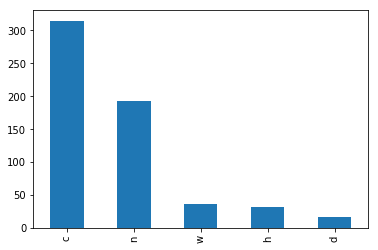

In [3]:
df['BrowserResult'].value_counts().plot.bar()

In [5]:
# Entfernen der fehlerhaften Bilder
df=df[((df['BrowserResult']=='c') | (df['BrowserResult']=='n'))]

#Der Parameter WaistAreadifferences wird in die Quartile WAD1-4 (von oben nach unten) aufgesplittet
for i in range(1,5):
    df['WAD'+str(i)]=df['WaistAreaDifferences'].apply(lambda x: abs(x[i-1]))

df.drop(['WaistAreaDifferences'], axis=1, inplace=True)

In [7]:
df.describe()

,MaxWaistAngle,MinWaistAngle,CurvatureDifference,CurvatureMaxDifference,ShoulderHeightDifference,WaistPointHeightDifference,HumpAngle,WAD1,WAD2,WAD3,WAD4
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,3.954028,-1.490088,0.002209,0.009733,0.003205,-0.000906,3.698948,0.266194,0.575737,0.911635,1.227024
std,4.230986,3.244045,0.001753,0.009677,0.051272,0.200789,4.912661,0.205244,0.435661,0.742594,0.985558
min,-6.170175,-18.853159,0.000009,0.000000,-0.151163,-1.630137,-10.561011,0.000000,0.000000,0.000000,0.005747
25%,0.720692,-2.977596,0.000904,0.003558,-0.033521,-0.069136,0.000000,0.112005,0.239747,0.372281,0.469494
50%,3.179830,-0.795724,0.001801,0.007228,0.000000,0.000000,3.576334,0.216049,0.484043,0.711538,0.971591
75%,6.044092,0.000000,0.003055,0.013706,0.035294,0.075949,6.709837,0.373476,0.812500,1.272566,1.745130
max,20.224859,6.674469,0.011735,0.107118,0.236111,1.272727,24.623565,1.159091,2.910891,4.051546,5.829897


## Röntgen Information

Hierbei werden die ebenfalls abgespeicherten Röntgenbildauswertungen mit einbezogen. Massgebend ist der höchste gemessene COBB-Winkel, sei es durch die Spline oder die traditionelle COBB-Methode.

In [8]:
df_x=pd.read_pickle('/Volumes/1TB/Users/peterbernstein/eclipse-workspace/Xrayexp1/xraydata/xray-labels-peter.pkl')

df_x=df_x.loc[~df_x.index.duplicated()]

df2=df_x.reindex(columns=['COBB_angles','val_COBB_angles'])
df2=df2.dropna()

#die höchsten gemessenen Winkel herausfinden
df2['MaxCOBB']=df2.applymap(lambda x: np.max(np.array(x), initial=1) ).aggregate(np.max, axis=1)


In [9]:
#Zusammenführen der Datenbanken
df3=pd.concat([df,df2['MaxCOBB']], axis=1)

# die COBB-Winkel der Kontrollen auf 0 setzen
def zeroCOBB(x):
    if '_k' in x.name:
        return 0
    else:
        return x.MaxCOBB
    
df3['MaxCOBB']=df3.apply(zeroCOBB, axis=1)

/Volumes/1TB/Users/peterbernstein/opt/anaconda3/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [10]:
df3=df3.dropna()

In [11]:
df3.describe()

,MaxWaistAngle,MinWaistAngle,CurvatureDifference,CurvatureMaxDifference,ShoulderHeightDifference,WaistPointHeightDifference,HumpAngle,WAD1,WAD2,WAD3,WAD4,MaxCOBB
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000
mean,3.935850,-1.503618,0.002213,0.009743,0.002784,-0.000697,3.700611,0.267106,0.579385,0.916904,1.227253,28.386965
std,4.235469,3.267929,0.001755,0.009776,0.051510,0.202928,4.919831,0.206991,0.439516,0.745439,0.985961,10.495526
min,-6.170175,-18.853159,0.000009,0.000000,-0.151163,-1.630137,-10.561011,0.000000,0.000000,0.000000,0.005747,0.000000
25%,0.716160,-2.997124,0.000914,0.003548,-0.034091,-0.069307,0.000000,0.108434,0.239747,0.384966,0.473354,23.000000
50%,3.179830,-0.795724,0.001804,0.007191,0.000000,0.000000,3.652223,0.216049,0.484848,0.720000,0.971591,28.000000
75%,6.004290,0.000000,0.003055,0.013682,0.035294,0.076018,6.709837,0.377156,0.812877,1.278066,1.739396,34.500000
max,20.224859,6.674469,0.011735,0.107118,0.236111,1.272727,24.623565,1.159091,2.910891,4.051546,5.829897,78.000000


## Gruppenbildung
Da es sich bislang um einen homogenen Datensatz Therapiebedürftiger handelt und die eigentliche Kontrollgruppe (Gesunde) noch fehlt, ist eine interne Stratifizierung in behandlungspflichtige (COBB >20°) und nicht unmittelbar behandlungspflichtige (haben ihr Korsett aus anderen Gründen bekommen) Skoliosen unternommen worden.

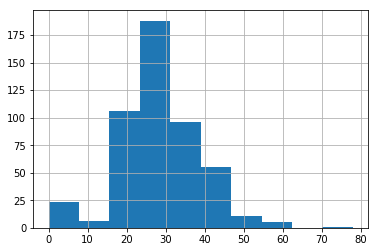

In [12]:
#Verteilung der COBB-Winkel
df3['MaxCOBB'].hist()

In [13]:
#über den Parameter COBBsplitter wird ein Klassifikator gebildet, der alle Winkel oberhalb eines Thresholds als 1 und darunter als 0 betrachtet
threshold=10
df3['COBBsplitter']=df3['MaxCOBB'].apply(lambda x: 1 if x>threshold else 0)

# Statistik

Zuerst soll die Verteilung entsprechend des COBBsplitters in den einzelnen Parametern betrachtet werden.

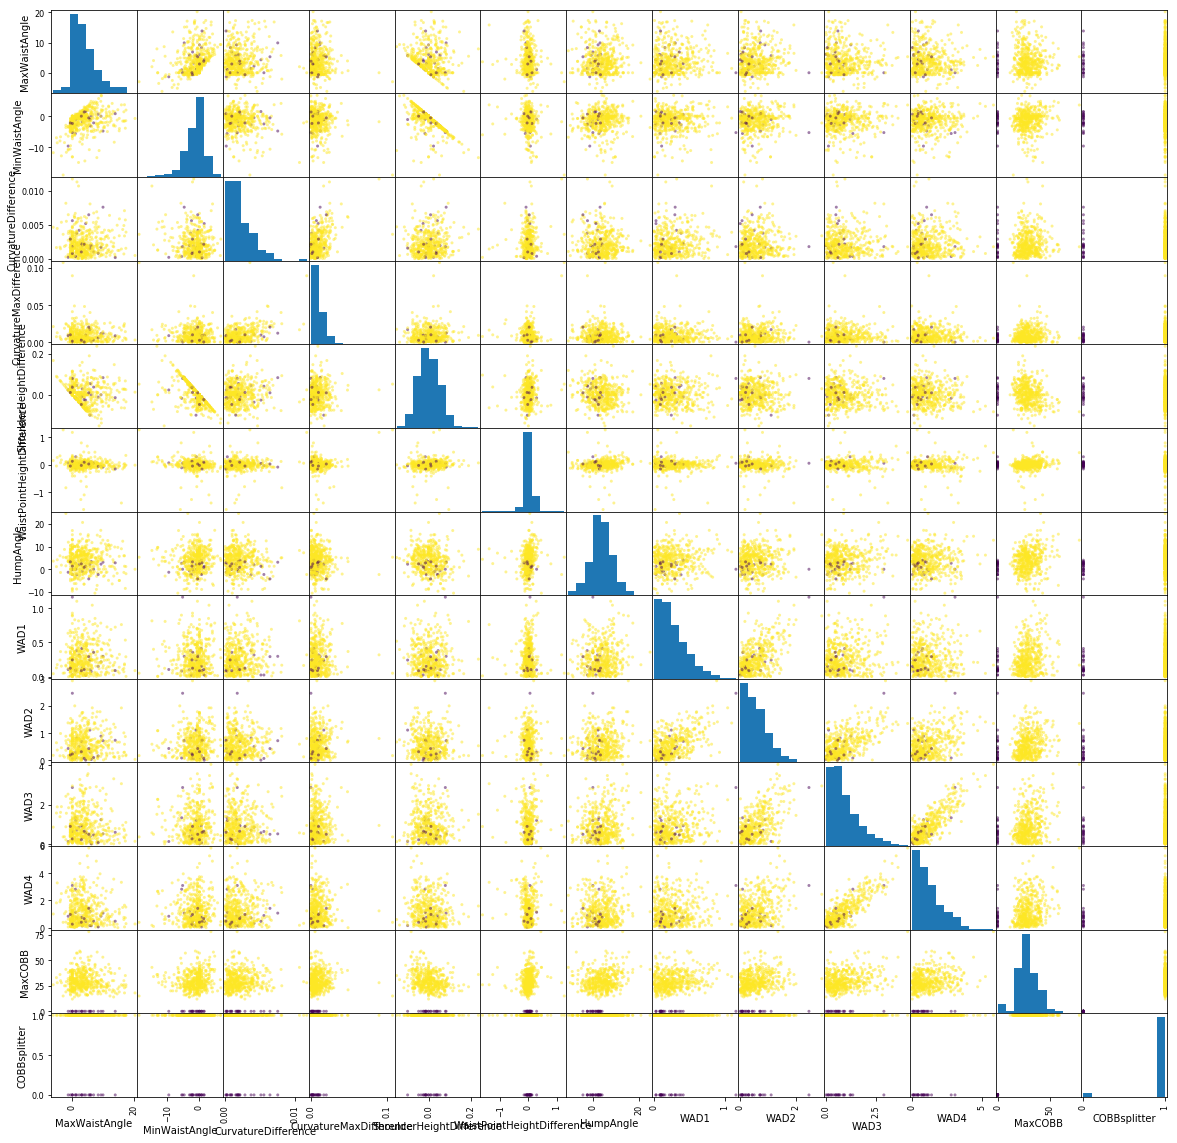

In [14]:

_=pd.plotting.scatter_matrix(df3, figsize=(20,20), c=df3['COBBsplitter'], grid=True)

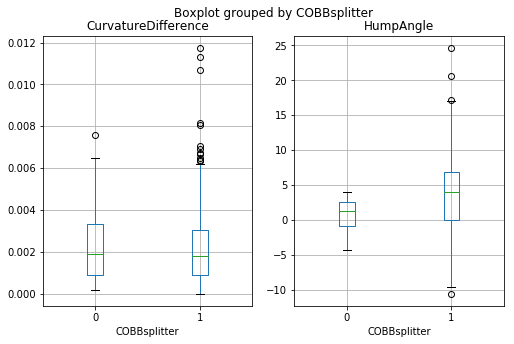

In [15]:
fig, ax=plt.subplots(1,2,figsize=(8,5))
df3.boxplot(column='CurvatureDifference',by='COBBsplitter', ax=ax[0])

df3.boxplot(column='HumpAngle',by='COBBsplitter', ax=ax[1])
plt.savefig('boxplots.png', bbox_inches='tight', pad_inches=0.2)

### Schlussfolgerung
Bei der Detektion des Rippenbuckels zwischen Kindern mit COBB-Winkel > 10° lässt sich ein Unterschied darstellen. Bei den Asymmetrien der Taillendreiecke ist dies nicht so einfach.

## Korrelationen

lassen sich einfache Korrelationen sehen, d.h. könnte mittels Regressionsanalyse die Frage beantwortet werden ?

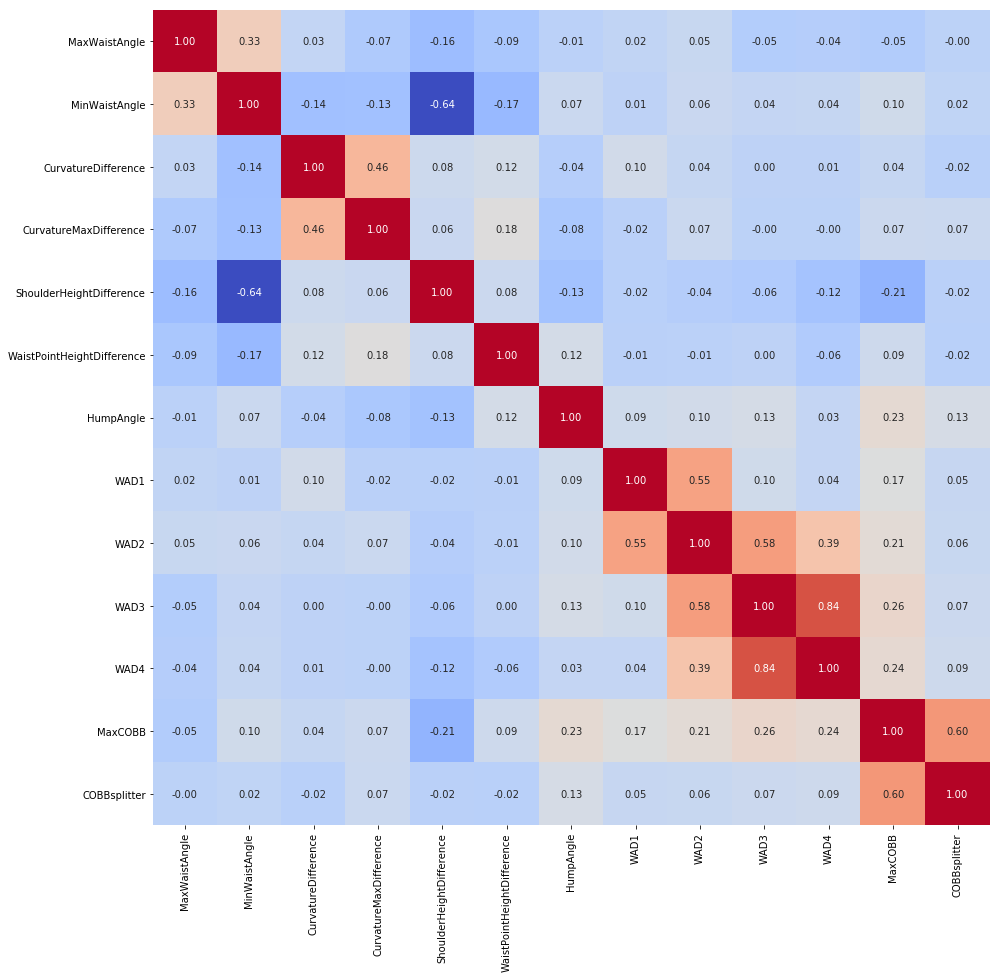

In [16]:
corr=df3.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.2f',cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('correlation_heatmap.png', bbox_inches='tight', pad_inches=0.2)


### Schlussfolgerung
Nein, die Koeffizienten sind so niedrig. Man kann nicht davon ausgehen, dass ein Zusammenhang von quantitativem COBB-Winkel mit irgendeinem klinischen Parameter besteht.

# Machine Learning

## Erläuterung des Prinzips
1. Bilden eines 2D-Vektors, zB (MaxWaistAngle * HumpAngle); Später werden alle Variablen einbezogen.
2. Targetvariable: COBBsplitter
3. Aufspalten des Datensatzes in Train und Test

In [17]:

Xtrain,Xtest,Ytrain,Ytest=train_test_split(df3[['MaxWaistAngle','HumpAngle']], df3['COBBsplitter'], random_state=0)

## K-nearest neighbor Modelle
### K-nearest neighbor Klassifizierer

In [18]:
clf=KNeighborsClassifier(n_neighbors=3)

clf.fit(Xtrain,Ytrain)
print('Accuracy des Testverfahrens: %.2f'%(clf.score(Xtest,Ytest)))

Accuracy des Testverfahrens: 0.93


### Entwicklung nach der Anzahl der Nachbarn

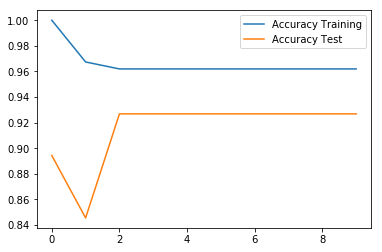

In [19]:
train_acc=[]
test_acc=[]

for n_neighbors in range(1,11):
    clf=KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(Xtrain,Ytrain)
    train_acc.append(clf.score(Xtrain,Ytrain))
    test_acc.append(clf.score(Xtest,Ytest))

plt.plot(train_acc, label='Accuracy Training')
plt.plot(test_acc, label='Accuracy Test')
plt.legend()

### K-neighbor Regressor

In [20]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(df3[['MaxWaistAngle','HumpAngle']], df3['MaxCOBB'], random_state=0)

In [21]:

reg = KNeighborsRegressor(n_neighbors=3)
reg.fit(Xtrain,Ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [22]:
print('R-Quadrat des Testverfahrens: %.2f'%(reg.score(Xtest,Ytest)))

R-Quadrat des Testverfahrens: -0.16


### Schlussfolgerung zu den KNN Modellen
Sie sind robust und funktionieren gut in der Kategorisierung. Für die Regression kommen sie nicht in Frage.

## Multivariate Modelle
Hierfür ist erneut die Konfiguration des Datensatzes notwendig. Wir werden alle körperlichen Skoliosemerkmale in X und den COBBsplitter (kategorial) oder MaxCOBB (Regression) als Y definieren.

### Lineares Regressionsmodell (Ridge Regression)

In [23]:
X=df3[['MaxWaistAngle', 'MinWaistAngle', 'CurvatureDifference',
       'CurvatureMaxDifference', 'ShoulderHeightDifference',
       'WaistPointHeightDifference', 'HumpAngle', 'WAD1',
       'WAD2', 'WAD3', 'WAD4']]
Y=df3['MaxCOBB']

In [24]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y, random_state=0)

In [25]:

ridge=Ridge().fit(Xtrain,Ytrain)

In [26]:
print('Score für Trainingsdaten %.2f'%ridge.score(Xtrain,Ytrain))

Score für Trainingsdaten 0.18


### Schlussfolgerung
Dies ist das dritte Verfahren (Korrelation, KNN, Ridge), welches bei der Regressionsanalyse scheitert, so dass man endgültig konstatieren muss, dass es keinen interindividuellen quantitativen Zusammenhang zwischen COBB-Winkel und klinischer Skolioseausprägung gibt. Dies sagt jedoch nicht, dass ein intraindividueller Zusammenhang im Schweregrad gesehen werden kann. Für diese Aussage haben wir derzeit und auf absehbare Zukunft keine Daten.

### Klassifikation mittels Random Forest

In [27]:
X=df3[['MaxWaistAngle', 'MinWaistAngle', 'CurvatureDifference',
       'CurvatureMaxDifference', 'ShoulderHeightDifference',
       'WaistPointHeightDifference', 'HumpAngle', 'WAD1',
       'WAD2', 'WAD3', 'WAD4']]
Y=df3['COBBsplitter']
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y, random_state=0)

In [28]:

forest=RandomForestClassifier(n_estimators=100,random_state=2)
forest.fit(Xtrain,Ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [29]:
print('Score für Trainingsdaten %.2f \nScore für Testdaten: %.2f'%(forest.score(Xtrain,Ytrain),forest.score(Xtest,Ytest)))

Score für Trainingsdaten 1.00 
Score für Testdaten: 0.93


In [30]:
def plot_feature_importance_skol(X,model):
    n_features=len(X.columns)
    plt.barh(range(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features),X.columns.to_list())
    plt.xlabel('Wichtigkeit des Merkmals')
    plt.ylabel('Merkmal')

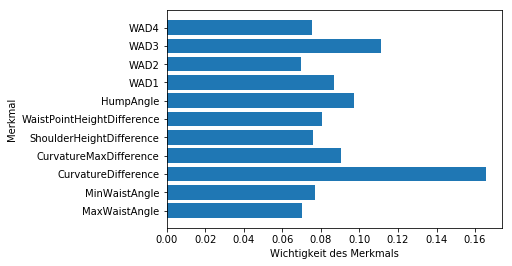

In [31]:
plot_feature_importance_skol(X,forest)

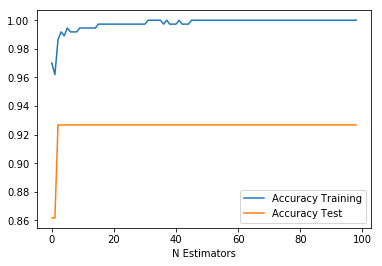

In [32]:
train_acc=[]
test_acc=[]

for n_estimators in range(1,100):
    forest=RandomForestClassifier(n_estimators=n_estimators,random_state=2)
    forest.fit(Xtrain,Ytrain)
    train_acc.append(forest.score(Xtrain,Ytrain))
    test_acc.append(forest.score(Xtest,Ytest))

plt.plot(train_acc, label='Accuracy Training')
plt.plot(test_acc, label='Accuracy Test')
plt.xlabel('N Estimators')
plt.legend()

### Klassifikation mittels GradientBoost RegressionTrees

In [33]:

gbst=GradientBoostingClassifier(random_state=2, max_depth=3)
gbst.fit(Xtrain,Ytrain)
print('Score für Trainingsdaten %.3f \nScore für Testdaten: %.3f'%(gbst.score(Xtrain,Ytrain),gbst.score(Xtest,Ytest)))

Score für Trainingsdaten 1.000 
Score für Testdaten: 0.919


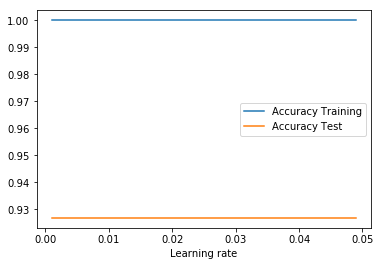

In [34]:
train_acc=[]
test_acc=[]
learningrates=[]

for lr in range(1,50):
    gbst=GradientBoostingClassifier(random_state=2, max_depth=2, learning_rate=0.001*lr)
    gbst.fit(Xtrain,Ytrain)
    train_acc.append(forest.score(Xtrain,Ytrain))
    test_acc.append(forest.score(Xtest,Ytest))
    learningrates.append(0.001*lr)

plt.plot(learningrates,train_acc, label='Accuracy Training')
plt.plot(learningrates,test_acc, label='Accuracy Test')
plt.xlabel('Learning rate')
plt.legend()

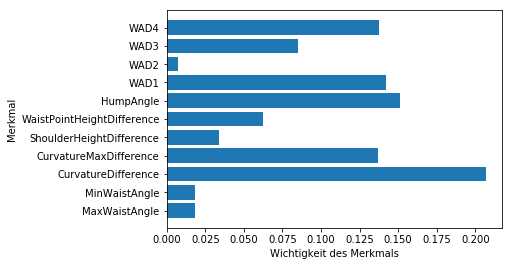

In [35]:
plot_feature_importance_skol(X,gbst)

### Schlussfolgerung zu den Bäumen und Wäldern
Wir erreichen mit dem derzeitigen Datensatz eine Accuracy von >80% zur Unterscheidung einer Behandlungspflichtigkeit der Skoliose, was aus meiner Sicht ein gutes Ergebnis ist - in Anbetracht der fehlenden Kontrollgruppe und der noch recht rudimentären Analyse (Präzision der Waistlines, fehlende Kontrollgruppe, etc.).

Bzgl. der Feature Importance lassen sich für mich noch keine Schlüsse ableiten - die Features werden von den Modellen unterschiedlich stark in Anspruch genommen.

## Für welchen Winkelwert eignet sich mein Klassifizierer?
Die Frage wäre nun, ob eine Veränderung des Thresholds zu einem besseren Ergebnis führen würde, um einen Ausblick auf den Effekt von Kontrollpatienten zu geben.

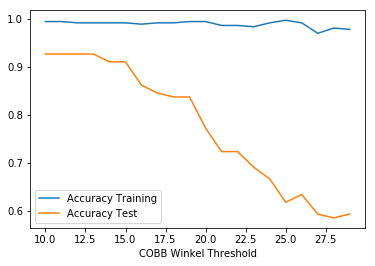

In [36]:
train_acc=[]
test_acc=[]
threshold_range=list(np.arange(10,30))

for threshold in threshold_range:
    df3['COBBsplitter']=df3['MaxCOBB'].apply(lambda x: 1 if x>threshold else 0)
    X=df3[['MaxWaistAngle', 'MinWaistAngle', 'CurvatureDifference',
       'CurvatureMaxDifference', 'ShoulderHeightDifference',
       'WaistPointHeightDifference', 'HumpAngle', 'WAD1',
       'WAD2', 'WAD3', 'WAD4']]
    Y=df3['COBBsplitter']
    Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y, random_state=0)

    forest=RandomForestClassifier(n_estimators=10,random_state=2)
    forest.fit(Xtrain,Ytrain)
    train_acc.append(forest.score(Xtrain,Ytrain))
    test_acc.append(forest.score(Xtest,Ytest))
    
plt.plot(threshold_range,train_acc, label='Accuracy Training')
plt.plot(threshold_range,test_acc, label='Accuracy Test')
plt.xlabel('COBB Winkel Threshold')
plt.legend()

plt.savefig('forestresult.png', bbox_inches='tight', pad_inches=0.2)

### Schlussfolgerung
Es ist zu erwarten, wenn der Threshold gegen 10° COBB-Winkel gelegt wird, dass die Accuracy über 95% geht. Somit werden wir unsere Aufgabe, ein System zu entwickeln, was anhand von Fotos einen gesunden von einem Skoliose-Rücken unterscheiden kann auf jeden Fall gerecht werden!!!

Eine weitere Steigerung der Präzision erwarte ich von
 - höherer Genauigkeit der Waistlines
 - Einbeziehen der Videodaten